<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Challenge 2 - Part 1 & 2: <strong>Data Preparation & Custom CNN</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>for cats_and_dogs dataset using neural networks</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Aprendizagem Profunda para Visão por Computador 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            color: #333;
            margin: 0;
            padding: 20px;
            line-height: 1.6;
        }
        ol {
            counter-reset: section;
            list-style: none;
            padding-left: 0;
        }
        /* First-level list */
        ol > li {
            counter-increment: section;
            margin-bottom: 10px;
            padding-left: 0;
        }
        ol > li::before {
            content: counters(section, ".") " ";
            font-weight: bold;
        }
        /* Second-level list */
        ol ol {
            counter-reset: subsection;
            padding-left: 20px;
            margin-top: 5px;
        }
        ol ol > li {
            counter-increment: subsection;
            margin-bottom: 5px;
            padding-left: 10px;
        }
        ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) " ";
            font-weight: bold;
        }
        /* Third-level list */
        ol ol ol {
            counter-reset: subsubsection;
            padding-left: 40px;
            margin-top: 5px;
        }
        ol ol ol > li {
            counter-increment: subsubsection;
            margin-bottom: 5px;
            padding-left: 10px;
            font-size: 0.9em; /* Make font size smaller */
            font-weight: normal; /* Remove bold styling */
        }
        ol ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) "." counter(subsubsection) " ";
            font-weight: bold;
        }
        a {
            text-decoration: none;
            color: #007BFF;
            font-weight: bold;
        }
        a:hover {
            color: #0056b3;
        }
        footer {
            margin-top: 50px;
        }
    </style>
</head>
<body>

<h2><b>Índice</b></h2>
<ol>
    <li><a href="#1">Objetivo desta parte</a></li>
    <li><a href="#2">Setup para desenvolvimento do projeto</a></li>
    <li><a href="#3">Classificação multi-classe</a></li>
        <ol>
            <li><a href="#3.1">Obter um conjunto de validação</a></li>
            <li><a href="#3.2">Construir o modelo</a></li>
            <li><a href="#3.3">Compilar a rede</a></li>
            <li><a href="#3.4">Treinar o modelo – max 50 épocas, de pref. a usar callbacks</a></li>
            <li><a href="#3.5">Gráfico que mostre a evolução do treino</a></li>
            <li><a href="#3.6">Cálculo dos acertos no conjunto de teste</a></li>
            <li><a href="#3.7">Mostrar a matriz de confusão</a></li>
        </ol>
    <li><a href="#4">Conversão da Classificação multi-classe para Binária</a></li>
    <li><a href="#5">Model Explanation</a></li>
</ol>

<footer></footer>

</body>
</html>

# <a class='anchor' id='1'></a>

> # **1. Objetivo desta parte** 

1. Carregar dataset
2. Separar validation em validation+test  
3. Ter em conta classificação binária
4. Ter em conta estratificação dos conjuntos de validação e teste

# <a class='anchor' id='2'></a>

> # **2. Setup para desenvolvimento do projeto**

In [4]:
import tensorflow as tf
import keras
from keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import cv2

import seaborn as sns
import sys
import os
from pathlib import Path

In [5]:
# Configurar a seed do TensorFlow
tf.keras.utils.set_random_seed(42)
# Definir a seed global para a operação de GPU
tf.config.experimental.enable_op_determinism()


# Definir o número de threads
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Para evitar log excessivo de TensorFlow
os.environ['OMP_NUM_THREADS'] = '1'  # Para limitar o número de threads

# Parte 1

In [6]:
%run ../src/cats_and_dogs.py

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Using 500 files for validation.
Train: 2000 samples, 50.00% dogs
Validation: 500 samples, 49.40% dogs
Test: 500 samples, 50.60% dogs


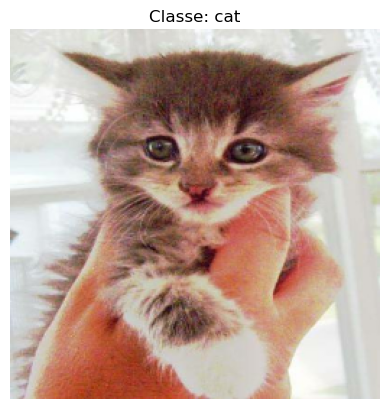

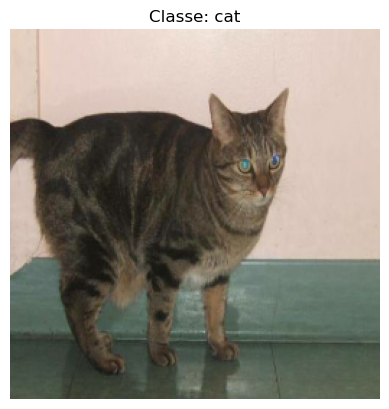

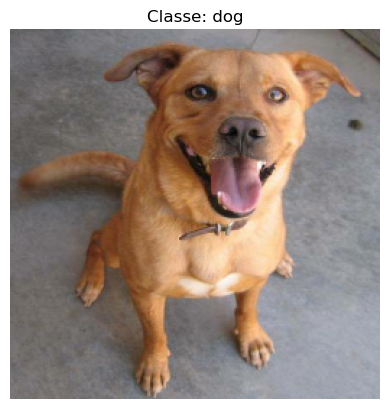

In [8]:
# Mostra umas imagens
for batch_x, batch_y in train:
    for i, x in enumerate(batch_x):
        if i >= 3:
            break
        x = np.asarray(x) / 255
        plt.imshow(x)
        plt.title(f'Classe: {labels[int(batch_y[i])]}')
        plt.axis('off')  # Esconder os eixos
        plt.show()
    break

# Parte 2

# <a class='anchor' id='3'></a>

> # **3. Classificação multi-classe**

# <a class='anchor' id='3.2'></a>

> ## **b) Construir o modelo**

In [5]:
# Baseline model
model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

In [6]:
best_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="tmp/baseline.weights.h5",      # ficheiro para os pesos do "melhor modelo"
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

# <a class='anchor' id='3.3'></a>

> ## **c) Compilar a rede**

In [7]:
# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# <a class='anchor' id='3.4'></a>

> ## **d) Treinar o modelo – max 50 épocas, de pref. a usar callbacks**


In [8]:
# Treinar o modelo (máx. 50 épocas, usando callbacks)
history = model.fit(train, epochs=50, 
                    validation_data=validation,
                    callbacks=[best_model_checkpoint, early_stopping])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 716ms/step - accuracy: 0.5062 - loss: 263.6086 - precision: 0.5012 - recall: 0.5167 - val_accuracy: 0.6440 - val_loss: 0.6489 - val_precision: 0.6012 - val_recall: 0.8300
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.6827 - loss: 0.6111 - precision: 0.6697 - recall: 0.7360 - val_accuracy: 0.6660 - val_loss: 0.6157 - val_precision: 0.6802 - val_recall: 0.6113
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.7755 - loss: 0.4816 - precision: 0.7804 - recall: 0.7719 - val_accuracy: 0.6840 - val_loss: 0.6304 - val_precision: 0.6773 - val_recall: 0.6883
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 393ms/step - accuracy: 0.8898 - loss: 0.3199 - precision: 0.8937 - recall: 0.8865 - val_accuracy: 0.6740 - val_loss: 0.6812 - val_precision: 0.6826 - val_recall: 0.6356
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.9244 - loss: 0.2144 - precision: 0.9328 - recall: 0.9164 - val_accuracy: 0.6620 - val_l

# <a class='anchor' id='3.5'></a>

> ## **e) Gráfico que mostre a evolução do treino**

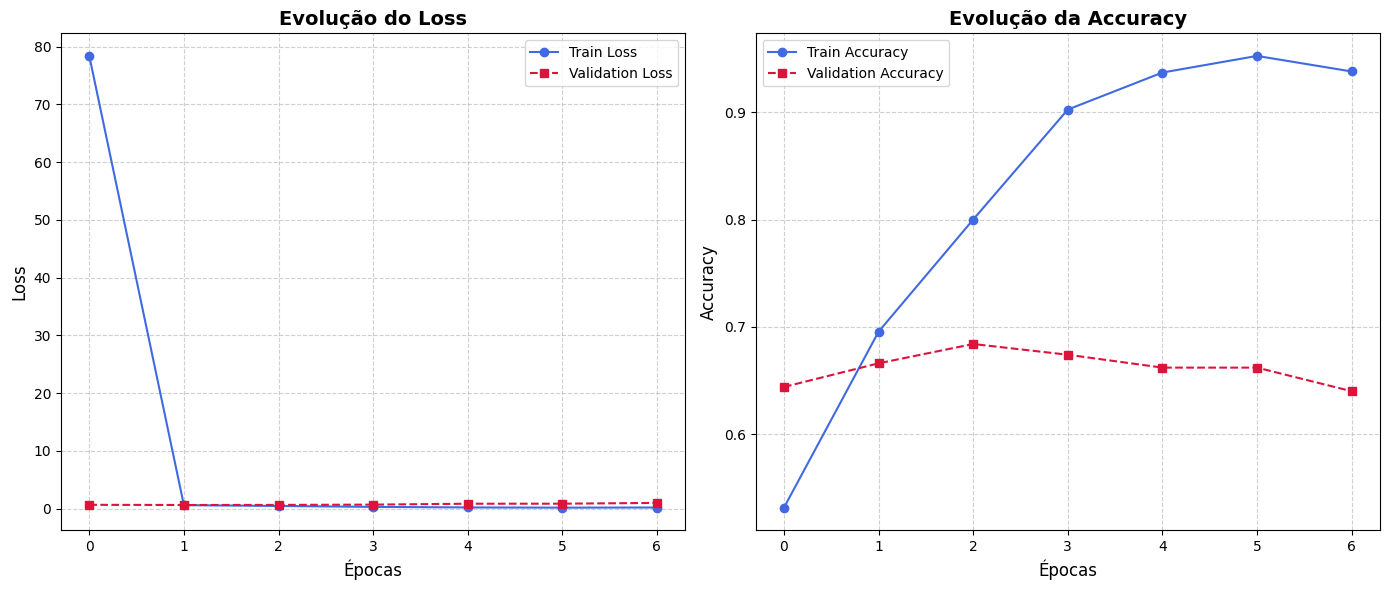

In [9]:
# Criar a figura
plt.figure(figsize=(14, 6))

# Subplot para Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='royalblue', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='crimson', linestyle='--', marker='s')
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot para Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='royalblue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='crimson', linestyle='--', marker='s')
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evolução da Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar espaçamento
plt.tight_layout()
plt.show()


In [10]:
# Carregar melhor modelo em validação
model.load_weights("tmp/baseline.weights.h5")

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,239,653 (96.28 MB)

 Trainable params: 8,413,217 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,826,436 (64.19 MB)

# <a class='anchor' id='3.6'></a>

> ## **f) Cálculo dos acertos no conjunto de teste**

In [12]:
train_list = list(train)
first_batch_x, first_batch_y = train_list[0]

In [13]:
len(train_labels)

2000

In [14]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test, verbose=0)[:2]
num_acertos = int(test_acc * len(train_labels))
print(f'Accuracy no conjunto de teste: {test_acc:.4f}')
print(f'Número absoluto de acertos: {num_acertos}/{len(train_labels)}')

Accuracy no conjunto de teste: 0.6360
Número absoluto de acertos: 1271/2000


# <a class='anchor' id='3.7'></a>

> ## **g) Mostrar a matriz de confusão**

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step 


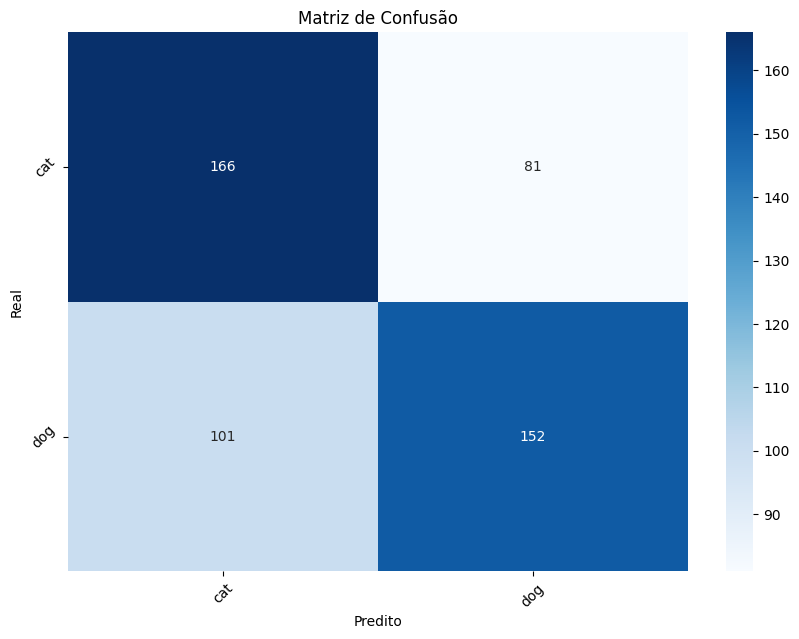

In [15]:
# Predições e matriz de confusão
y_pred = model.predict(test)
y_pred_classes = y_pred.squeeze()>0.5
y_true_classes = test_labels.squeeze()

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [16]:
# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

Relatório de Classificação:
              precision    recall  f1-score   support

         cat       0.62      0.67      0.65       247
         dog       0.65      0.60      0.63       253

    accuracy                           0.64       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.64      0.64      0.64       500



# <a class='anchor' id='5'></a>

> # **5. Model Explanation**

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,239,653 (96.28 MB)

 Trainable params: 8,413,217 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,826,436 (64.19 MB)

In [18]:
linear_model = tf.keras.models.Model(inputs=[model.layers[0].input], outputs=[model.layers[-2].output])

In [19]:
train_preds = model.predict(train).squeeze()

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


In [20]:
labels

['cat', 'dog']

In [21]:
train_list = list(train)

In [22]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([0])

In [26]:
saliency = Saliency(model, clone=False)

C:\Users\Avey\miniforge3\envs\apvc\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 256, 256, 3))']
  warnings.warn(msg)


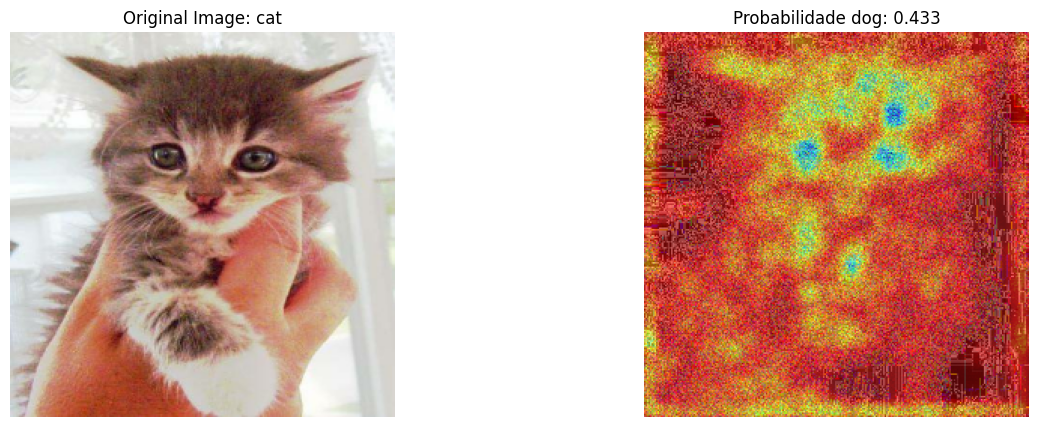

In [27]:
# Load and preprocess an example image
img_id = 0 # 5656
img = train_list[0][0][img_id]  # Tensor
img_array = np.expand_dims(img, axis = 0)  # Normalize and add batch dimension, now numpy array
# Compute saliency map
saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.2)
saliency_map = normalize(saliency_map)
# Overlay saliency map on original image
heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map).squeeze(), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(heatmap, 0.6, np.uint8(255 * img), 0.4, 0)

# Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img.numpy().astype("uint8"))
ax[0].set_title(f"Original Image: {labels[int(train_list[0][1][img_id])]}")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title(f"Probabilidade {labels[1]}: {train_preds[img_id]:.3f}")
ax[1].axis("off")

plt.show()


# Modelo pré-treinado

In [28]:
from keras.src.applications.mobilenet_v3 import decode_predictions

In [29]:
from tensorflow.keras.applications import MobileNetV3Small

model = MobileNetV3Small(input_shape=(img_height, img_width, 3))
test_list = list(test)

preds = model.predict(test)

C:\Users\Avey\miniforge3\envs\apvc\lib\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step


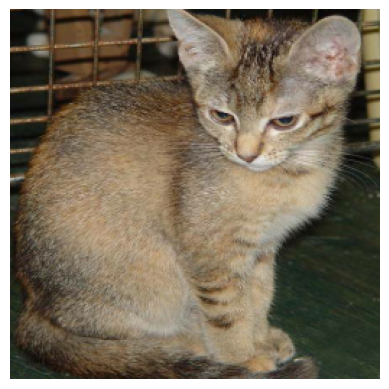

Predicted: 
Egyptian_cat  :  0.24275774
tabby  :  0.2124405
tiger_cat  :  0.21242653
lynx  :  0.05199043
cougar  :  0.0033464767


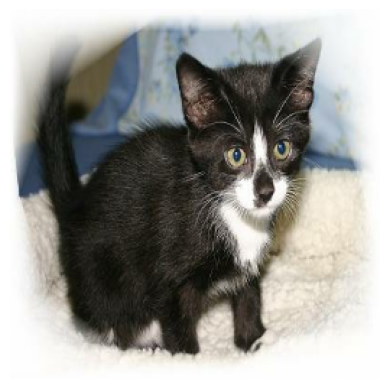

Predicted: 
Egyptian_cat  :  0.2754639
tabby  :  0.106071085
papillon  :  0.033167135
bathtub  :  0.03239488
tiger_cat  :  0.03150559


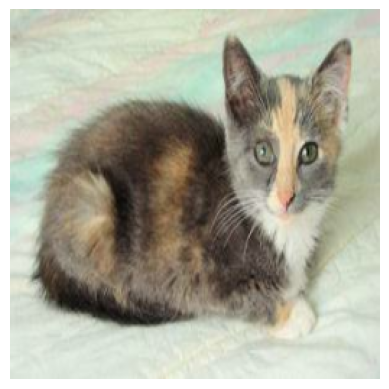

Predicted: 
tabby  :  0.34578985
Egyptian_cat  :  0.17063978
tiger_cat  :  0.060579617
Persian_cat  :  0.021341592
lynx  :  0.017459136


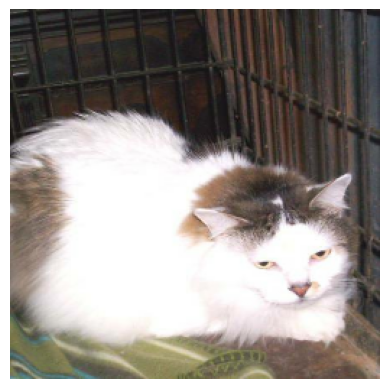

Predicted: 
Angora  :  0.320331
Persian_cat  :  0.11547748
Pomeranian  :  0.030702926
guinea_pig  :  0.021978568
Shetland_sheepdog  :  0.018901061


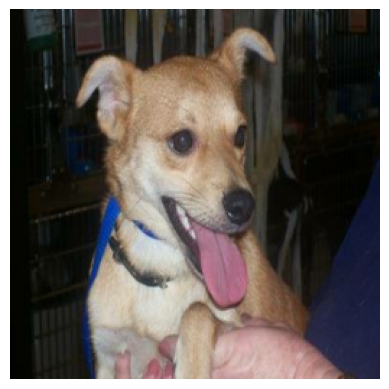

Predicted: 
Chihuahua  :  0.53987676
Pembroke  :  0.041092303
toy_terrier  :  0.03928535
Italian_greyhound  :  0.01935951
dingo  :  0.019127326


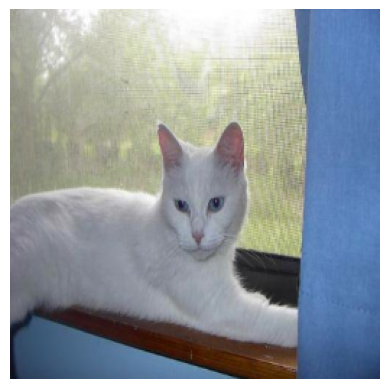

Predicted: 
Siamese_cat  :  0.29985914
Egyptian_cat  :  0.10052715
window_screen  :  0.03560983
tabby  :  0.0210621
Eskimo_dog  :  0.014485334


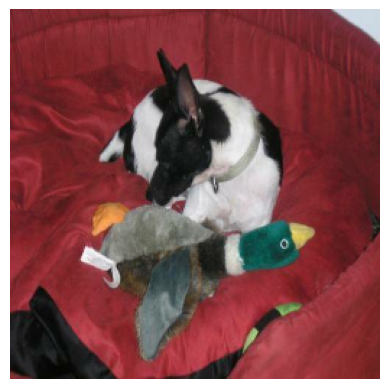

Predicted: 
Boston_bull  :  0.5195632
sleeping_bag  :  0.10801933
Cardigan  :  0.064266555
French_bulldog  :  0.036234654
guinea_pig  :  0.026532285


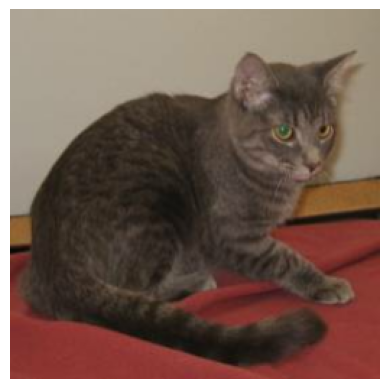

Predicted: 
tabby  :  0.2960241
tiger_cat  :  0.15986368
Egyptian_cat  :  0.15620232
velvet  :  0.016148485
Persian_cat  :  0.010914181


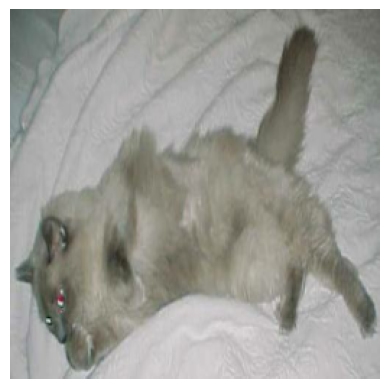

Predicted: 
Great_Pyrenees  :  0.119665086
keeshond  :  0.0998297
Norwegian_elkhound  :  0.09416055
Siamese_cat  :  0.08600862
Siberian_husky  :  0.0821014


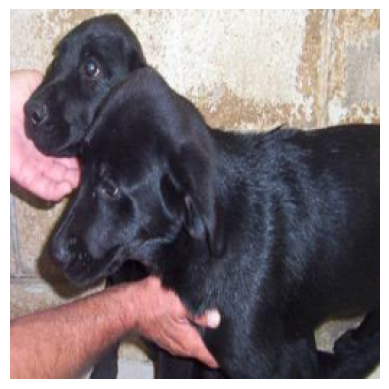

Predicted: 
Labrador_retriever  :  0.49256855
flat-coated_retriever  :  0.24746746
schipperke  :  0.028131414
Great_Dane  :  0.025813198
kelpie  :  0.024672799


In [ ]:
decoded_preds = decode_predictions(preds, top=5)
for img, pred in enumerate(decoded_preds[:3]):
    plt.imshow(np.array(test_list[0][0][img])/255)
    plt.axis('off')
    plt.show()
    print('Predicted: ')
    for pred_class in pred:
        print(pred_class[1], " : ", pred_class[2])

# Transfer Learning

In [31]:
mobileNetModel = MobileNetV3Small(input_shape=(img_height, img_width, 3), include_top=False)
mobileNetModel.summary()
mobileNetModel.trainable = False

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 128, 128, 16)      │             432 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 128, 128, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_19 (Activation)    │ (None, 128, 128, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_pad   │ (None, 129, 129, 16)      │               0 │ activation_19[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 16)        │             144 │ expanded_conv_depthwise_p… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 64, 64, 16)        │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 64, 64, 16)        │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │               0 │ re_lu_14[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │             136 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │               0 │ expanded_conv_squeeze_exc… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │             144 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_9 (Add)                   │ (None, 1, 1, 16)          │               

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [32]:
model = tf.keras.models.Sequential([
    layers.Input((img_height, img_width, 3)),
    layers.Rescaling(2./255, offset=-1),
    mobileNetModel,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 8, 8, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,376,817 (39.58 MB)

 Trainable params: 9,437,697 (36.00 MB)

 Non-trainable params: 939,120 (3.58 MB)

# <a class='anchor' id='3.3'></a>

> ## **c) Compilar a rede**

In [34]:
# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# <a class='anchor' id='3.4'></a>

> ## **d) Treinar o modelo – max 50 épocas, de pref. a usar callbacks**


In [35]:
# Treinar o modelo (máx. 50 épocas, usando callbacks)
history = model.fit(train, epochs=50, 
                    validation_data=validation,
                    callbacks=[best_model_checkpoint, early_stopping])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - accuracy: 0.5318 - loss: 3.4327 - precision_1: 0.5335 - recall_1: 0.5595 - val_accuracy: 0.6700 - val_loss: 0.6511 - val_precision_1: 0.6881 - val_recall_1: 0.6073
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.6314 - loss: 0.6503 - precision_1: 0.6397 - recall_1: 0.6112 - val_accuracy: 0.6760 - val_loss: 0.6250 - val_precision_1: 0.7348 - val_recall_1: 0.5385
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.6428 - loss: 0.6302 - precision_1: 0.6458 - recall_1: 0.6411 - val_accuracy: 0.6820 - val_loss: 0.6103 - val_precision_1: 0.7292 - val_recall_1: 0.5668
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - accuracy: 0.6580 - loss: 0.6060 - precision_1: 0.6835 - recall_1: 0.5958 - val_accuracy: 0.6840 - val_loss: 0.6023 - val_precision_1: 0.7730 - val_recall_1: 0.5101
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.6581 - loss: 0.6108 - precision_1: 0.6767 - recall_1: 0.6

# <a class='anchor' id='3.5'></a>

> ## **e) Gráfico que mostre a evolução do treino**

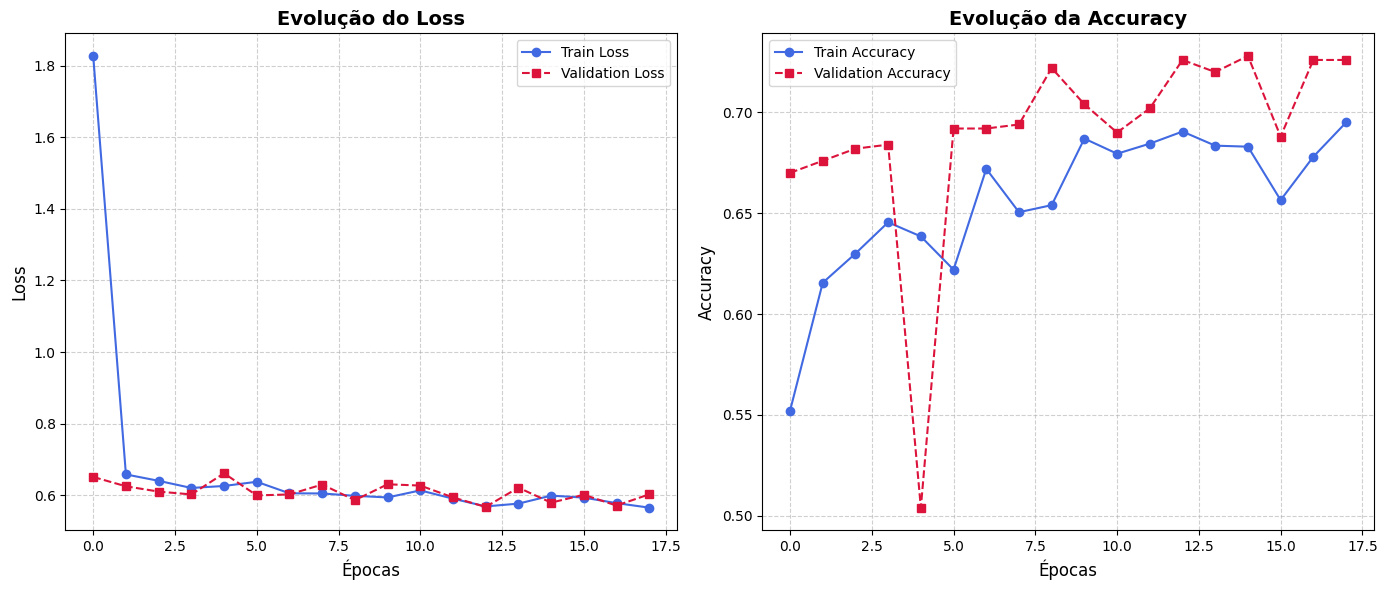

In [36]:
# Criar a figura
plt.figure(figsize=(14, 6))

# Subplot para Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='royalblue', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='crimson', linestyle='--', marker='s')
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot para Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='royalblue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='crimson', linestyle='--', marker='s')
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evolução da Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar espaçamento
plt.tight_layout()
plt.show()


In [37]:
# Carregar melhor modelo em validação
model.load_weights("tmp/baseline.weights.h5")

In [38]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 8, 8, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,252,213 (111.59 MB)

 Trainable params: 9,437,697 (36.00 MB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 18,875,396 (72.00 MB)

# <a class='anchor' id='3.6'></a>

> ## **f) Cálculo dos acertos no conjunto de teste**

In [39]:
train_list = list(train)
first_batch_x, first_batch_y = train_list[0]

In [40]:
len(train_labels)

2000

In [41]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test, verbose=0)[:2]
num_acertos = int(test_acc * len(train_labels))
print(f'Accuracy no conjunto de teste: {test_acc:.4f}')
print(f'Número absoluto de acertos: {num_acertos}/{len(train_labels)}')

Accuracy no conjunto de teste: 0.7060
Número absoluto de acertos: 1411/2000


# <a class='anchor' id='3.7'></a>

> ## **g) Mostrar a matriz de confusão**

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step


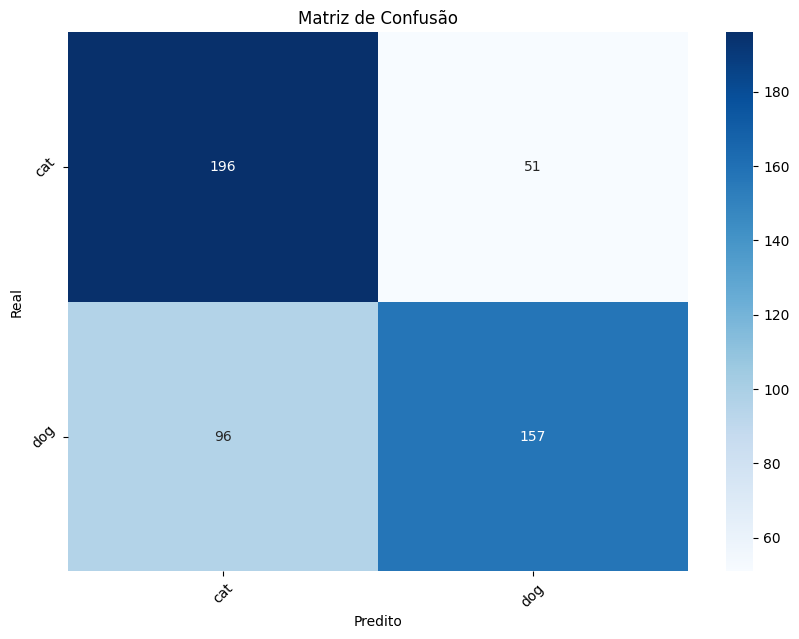

In [42]:
# Predições e matriz de confusão
y_pred = model.predict(test)
y_pred_classes = y_pred.squeeze()>0.5
y_true_classes = test_labels.squeeze()

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [43]:
# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

Relatório de Classificação:
              precision    recall  f1-score   support

         cat       0.67      0.79      0.73       247
         dog       0.75      0.62      0.68       253

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.70       500
weighted avg       0.71      0.71      0.70       500



In [44]:
linear_model = tf.keras.models.Model(inputs=[model.layers[0].input], outputs=[model.layers[-2].output])

In [45]:
train_preds = model.predict(train).squeeze()

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step


In [46]:
labels

['cat', 'dog']

In [47]:
train_list = list(train)

C:\Users\Avey\miniforge3\envs\apvc\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 256, 256, 3))']
  warnings.warn(msg)


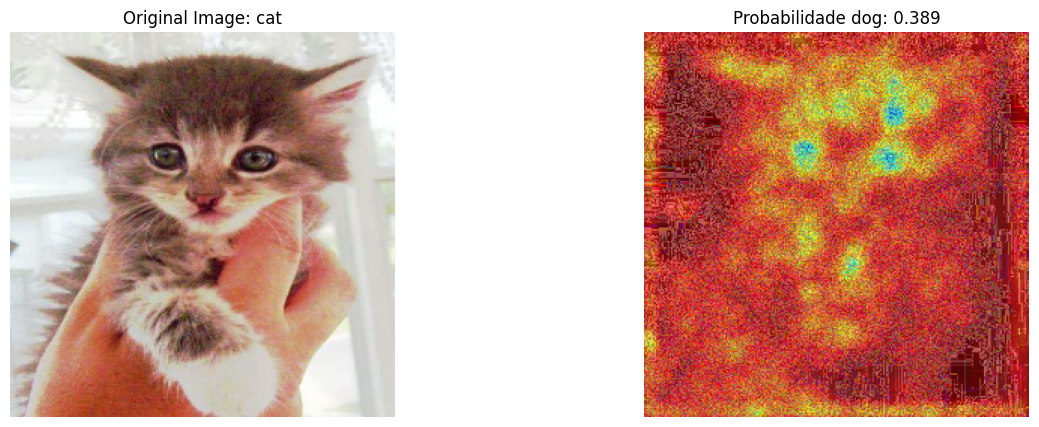

In [48]:
# Load and preprocess an example image
img_id = 0 # 5656
img = train_list[0][0][img_id]  # Tensor
img_array = np.expand_dims(img, axis = 0)  # Normalize and add batch dimension, now numpy array
# Compute saliency map
saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.2)
saliency_map = normalize(saliency_map)
# Overlay saliency map on original image
heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map).squeeze(), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(heatmap, 0.6, np.uint8(255 * img), 0.4, 0)

# Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img.numpy().astype("uint8"))
ax[0].set_title(f"Original Image: {labels[int(train_list[0][1][img_id])]}")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title(f"Probabilidade {labels[1]}: {train_preds[img_id]:.3f}")
ax[1].axis("off")

plt.show()
